# Initialize Colab Environment

**Note 1: Sometimes the colab notebook runtimes 'break' and you get runtime errors for no reason. In these cases, restart the runtime by clicking 'Runtime' -> 'Restart Runtime' and run everything in this section again.**

**Note 2: If you care about speed, make sure your colab runtime uses a GPU. Do this by selecting 'Runtime' -> 'Change Runtime Type' -> 'Hardware Accelerator' -> 'GPU' (the runtime will restart and you'll have to re-run this section).**

We're going to mount your Google Drive first, using the command below. Just follow the prompts.

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Next, we're going to change the directory to your drive, and make a folder for the tutorial. If any of these steps has been done before, it will simply be skipped (and throw an error message, which you can ignore).

In [3]:
%cd ~
%cd /content/drive/My\ Drive/
%mkdir wgan-tutorial
%cd wgan-tutorial

#eventually put our replication repo here
#!git clone https://github.com/gsbDBI/ds-wgan/

/root
/content/drive/My Drive
mkdir: cannot create directory ‘wgan-tutorial’: File exists
/content/drive/My Drive/wgan-tutorial


Next, install the wgan package written for the project:

In [4]:
#!pip3 uninstall wgan
#!pip3 install git+https://github.com/gsbDBI/ds-wgan.git@package#egg=wgan
!pip install git+https://github.com/gsbDBI/ds-wgan

  Cloning https://github.com/gsbDBI/ds-wgan to /tmp/pip-req-build-i5yi84_9
  Running command git clone --filter=blob:none --quiet https://github.com/gsbDBI/ds-wgan /tmp/pip-req-build-i5yi84_9
  Resolved https://github.com/gsbDBI/ds-wgan to commit ee7fa679dfda852cdb04cef211f2370599e657b6
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1

# Simulating Data

The workflow for every single distribution you want to fit:

0.   Load and prepare the data
1.   Initialize a `wgan.DataWrapper` object, which takes care of handling the data
2.   Initialize `wgan.Specifications` object given the `DataWrapper`, which summarizes hyperparameters, etc.
3.   Initialize `wgan.Generator` & `wgan.Critic` given the `Specifications`
4.   Preprocess the data with the `DataWrapper` object
5.   Train the `Generator` & `Critic` via `wgan.train`
6.   Replace columns in df with simulated data from `Generator` using `DataWrapper.apply_generator`
7.   If you're interested in them, add the `Critic` outputs to the original and/or the generated df via `DataWrapper.apply_critic`
7.   Explore the data via `compare_dfs` & save the new data.

Since **we're fitting two distributions** (Y on X and t, as well as X on t), we'll have to do all these steps twice.
To keep the code concise, we will put the two versions of every obejct type into one list respectively. Watch out so you **don't get confused by that**!


## Steps 0-3

First load a data file from our project repo

In [5]:
import pandas as pd
import wgan
import io
import requests

In [17]:
# df = pd.read_csv('df_train.csv')
# df = pd.read_csv('df_independent_train.csv')
# df = pd.read_csv('df_smallp_train.csv')
# df = pd.read_csv('df_complex_train.csv')
df = pd.read_csv('df_0.2SNR_train.csv')
df.head(10)

,t,cat1,cat2,cat3,cont1,cont2,cont3,y
0,1.0,0.0,0.0,0.0,-1.612848,0.942164,0.208279,1.308873
1,0.0,0.0,0.0,0.0,1.097744,1.070093,-1.741389,4.071360
2,0.0,0.0,0.0,0.0,-0.142925,0.123477,0.449124,1.315711
3,1.0,0.0,1.0,1.0,-1.790287,-0.930864,1.181038,3.479074
4,0.0,0.0,0.0,1.0,0.316106,-0.749269,0.025863,-2.167903
5,0.0,0.0,0.0,0.0,0.609385,0.430796,-0.996516,-1.016956
6,1.0,0.0,1.0,0.0,-1.098644,-0.007543,-0.032593,0.807495
7,1.0,1.0,1.0,0.0,-0.484988,0.366984,-1.219561,12.406929
8,1.0,0.0,0.0,1.0,-1.081698,0.052486,0.648742,1.239830
9,0.0,0.0,1.0,0.0,-1.445126,1.138726,0.092752,-5.862212


In [18]:
df.shape

(4000, 8)

After loading in our data as `df`, we will build from it second dataframe called `df_balanced`, by sampling treated and controls with similar probability from `df`. We will train our WGAN on `df_balanced`, which makes sure the quality of the generated outcomes is similar for both treatment groups.



In [19]:
# df_balanced = df.sample(2*len(df), weights=(1-df.t.mean())*df.t+df.t.mean()*(1-df.t), replace=True) # balanced df for training
df_balanced = df.sample(2*len(df), weights=(1-df.cat1.mean())*df.cat1+df.cat1.mean()*(1-df.cat1), replace=True) # balanced protected var df for training

# X | t
continuous_vars_0 = ['cont1', 'cont2', 'cont3']
continuous_lower_bounds_0 = {}   # "re74": 0, "re75": 0
categorical_vars_0 = ['cat1', 'cat2', 'cat3']
context_vars_0 = ["t"]

# Y | X, t
continuous_vars_1 = ["y"]
continuous_lower_bounds_1 = {}
categorical_vars_1 = []
context_vars_1 = ["t", 'cont1', 'cont2', 'cont3', 'cat1', 'cat2', 'cat3']

# Initialize objects
data_wrappers = [wgan.DataWrapper(df_balanced, continuous_vars_0, categorical_vars_0,
                                  context_vars_0, continuous_lower_bounds_0),
                 wgan.DataWrapper(df_balanced, continuous_vars_1, categorical_vars_1,
                                  context_vars_1, continuous_lower_bounds_1)]
specs = [wgan.Specifications(dw, batch_size=1024, max_epochs=1000, critic_lr=1e-3, generator_lr=1e-3,
                             print_every=100, device = "cuda") for dw in data_wrappers]
generators = [wgan.Generator(spec) for spec in specs]
critics = [wgan.Critic(spec) for spec in specs]

settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.001, 'generator_d_noise': 9, 'generator_optimizer': 'optimizer', 'max_epochs': 1000, 'batch_size': 1024, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cuda'}
settings: {'optimizer': <class 'torch.optim.adam.Adam'>, 'critic_d_hidden': [128, 128, 128], 'critic_dropout': 0, 'critic_steps': 15, 'critic_lr': 0.001, 'critic_gp_factor': 5, 'generator_d_hidden': [128, 128, 128], 'generator_dropout': 0.1, 'generator_lr': 0.001, 'generator_d_noise': 1, 'generator_optimizer': 'optimizer', 'max_epochs': 1000, 'batch_size': 1024, 'test_set_size': 16, 'load_checkpoint': None, 'save_checkpoint': None, 'save_every': 100, 'print_every': 100, 'device': 'cuda'}


## Steps 4 & 5

Next, we train the model. How long this will take depends on the batch_size, the size of your data set and the max_epochs you specified.

You can also abort at any time, the model will keep its parameters at their most recent values during training. You can also resume the training, but this resets the optimizer state which basically means you might as well repeat at Step 3.

In [20]:
# train X | t
x, context = data_wrappers[0].preprocess(df_balanced)
wgan.train(generators[0], critics[0], x, context, specs[0])

epoch 0 | step 9 | WD_test 0.3 | WD_train 0.14 | sec passed 0 |
epoch 100 | step 809 | WD_test 0.72 | WD_train 0.81 | sec passed 13 |
epoch 200 | step 1609 | WD_test 0.18 | WD_train 0.41 | sec passed 11 |
epoch 300 | step 2409 | WD_test 0.65 | WD_train 0.66 | sec passed 11 |
epoch 400 | step 3209 | WD_test 0.26 | WD_train 0.56 | sec passed 16 |
epoch 500 | step 4009 | WD_test 0.16 | WD_train 0.37 | sec passed 11 |
epoch 600 | step 4809 | WD_test 0.29 | WD_train 0.34 | sec passed 12 |
epoch 700 | step 5609 | WD_test 0.08 | WD_train 0.31 | sec passed 11 |
epoch 800 | step 6409 | WD_test 0.06 | WD_train 0.38 | sec passed 11 |
epoch 900 | step 7209 | WD_test 0.11 | WD_train 0.3 | sec passed 11 |


In [21]:
# train Y | X, t
x, context = data_wrappers[1].preprocess(df_balanced)
wgan.train(generators[1], critics[1], x, context, specs[1])

epoch 0 | step 9 | WD_test 0.08 | WD_train 0.03 | sec passed 0 |
epoch 100 | step 809 | WD_test -0.13 | WD_train 0.17 | sec passed 11 |
epoch 200 | step 1609 | WD_test 0.16 | WD_train 0.23 | sec passed 11 |
epoch 300 | step 2409 | WD_test 0.64 | WD_train 0.28 | sec passed 12 |
epoch 400 | step 3209 | WD_test 0.31 | WD_train 0.31 | sec passed 12 |
epoch 500 | step 4009 | WD_test 0.32 | WD_train 0.34 | sec passed 11 |
epoch 600 | step 4809 | WD_test 0.15 | WD_train 0.34 | sec passed 10 |
epoch 700 | step 5609 | WD_test 0.34 | WD_train 0.33 | sec passed 11 |
epoch 800 | step 6409 | WD_test 0.38 | WD_train 0.33 | sec passed 11 |
epoch 900 | step 7209 | WD_test 0.15 | WD_train 0.32 | sec passed 11 |


## Steps 6 & 8

In [22]:
# simulate data with conditional WGANs
df_generated = data_wrappers[0].apply_generator(generators[0], df.sample(int(1e6), replace=True))
df_generated = data_wrappers[1].apply_generator(generators[1], df_generated)


# add counterfactual outcomes
from copy import copy
df_generated_cf = copy(df_generated)
df_generated_cf["t"] = 1 - df_generated_cf["t"]
df_generated["y_cf"] = data_wrappers[1].apply_generator(generators[1], df_generated_cf)["y"]

# save to .feather
#df_generated.to_feather("data/generated/{}_generated.feather".format(name))

In [23]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data as D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time

def compare_dfs(df_real, df_fake, scatterplot=dict(x=[], y=[], samples=400, smooth=0),
                table_groupby=[], histogram=dict(variables=[], nrow=1, ncol=1),
                figsize=3,save=False,path=""):
    """
    Diagnostic function for comparing real and generated data from WGAN models.
    Prints out comparison of means, comparisons of standard deviations, and histograms
    and scatterplots.

    Parameters
    ----------
    df_real: pandas.DataFrame
        real data
    df_fake: pandas.DataFrame
        data produced by generator
    scatterplot: dict
        Contains specifications for plotting scatterplots of variables in real and fake data
    table_groupby: list
        List of variables to group mean and standard deviation table by
    histogram: dict
        Contains specifications for plotting histograms comparing marginal densities
        of real and fake data
    save: bool
        Indicate whether to save results to file or print them
    path: string
        Path to save diagnostics for model
    """
    # data prep
    if "source" in list(df_real.columns): df_real = df_real.drop("source", axis=1)
    if "source" in list(df_fake.columns): df_fake = df_fake.drop("source", axis=1)
    df_real.insert(0, "source", "real"), df_fake.insert(0, "source", "fake")
    common_cols = [c for c in df_real.columns if c in df_fake.columns]
    df_joined = pd.concat([df_real[common_cols], df_fake[common_cols]], axis=0, ignore_index=True)
    df_real, df_fake = df_real.drop("source", axis=1), df_fake.drop("source", axis=1)
    common_cols = [c for c in df_real.columns if c in df_fake.columns]
    print(common_cols)
    # mean and std table

    means = df_joined.groupby(table_groupby + ["source"]).mean().round(2).transpose()
    if save:
        means.to_csv(path+"_means.txt",sep=" ")
    else:
        print("-------------comparison of means-------------")
        print(means)

    stds = df_joined.groupby(table_groupby + ["source"]).std().round(2).transpose()

    if save:
        stds.to_csv(path+"_stds.txt",sep=" ")
    else:
        print("-------------comparison of stds-------------")
        print(stds)
    # covariance matrix comparison
    fig1 = plt.figure(figsize=(figsize * 2, figsize * 1))
    s1 = [fig1.add_subplot(1, 2, i) for i in range(1, 3)]
    s1[0].set_xlabel("real")
    s1[1].set_xlabel("fake")
    s1[0].matshow(df_real[common_cols].corr())
    s1[1].matshow(df_fake[common_cols].corr())
    # histogram marginals
    if histogram and len(histogram["variables"]) > 0:
        fig2, axarr2 = plt.subplots(histogram["nrow"], histogram["ncol"],
                                    figsize=(histogram["nrow"]*(figsize), histogram["ncol"]*(figsize)))
        v = 0
        for i in range(histogram["nrow"]):
            for j in range(histogram["ncol"]):
                plot_var, v = histogram["variables"][v], v+1
                # axarr2[i][j].hist([df_real[plot_var], df_fake[plot_var]], bins=8, density=1,
                                  #  histtype='bar', label=["real", "fake"], color=["blue", "red"])
                print()
                axarr2[i][j].hist([df_real[plot_var], df_fake[plot_var]], bins=8, weights=[np.ones_like(df_real[plot_var])/len(df_real[plot_var]), np.ones_like(df_fake[plot_var])/len(df_fake[plot_var])],
                                  histtype='bar', label=["real", "fake"], color=["blue", "red"])
                axarr2[i][j].legend(prop={"size": 10})
                axarr2[i][j].set_title(plot_var)
        if save:
            fig2.savefig(path+'_hist.png')
        else:
            fig2.show()
    # scatterplot grid
    if scatterplot and len(scatterplot["x"]) * len(scatterplot["y"]) > 0:
        df_real_sample = df_real.sample(scatterplot["samples"])
        df_fake_sample = df_fake.sample(scatterplot["samples"])
        x_vars, y_vars = scatterplot["x"], scatterplot["y"]
        fig3 = plt.figure(figsize=(len(x_vars) * (figsize), len(y_vars) * figsize))
        s3 = [fig3.add_subplot(len(y_vars), len(x_vars), i + 1) for i in range(len(x_vars) * len(y_vars))]
        count = 0
        for y in y_vars:
            for x in x_vars:
                s = s3.pop(0)
                x_real, y_real = df_real_sample[x].to_numpy(),  df_real_sample[y].to_numpy()
                x_fake, y_fake = df_fake_sample[x].to_numpy(), df_fake_sample[y].to_numpy()
                from math import sqrt,pi
                def fit(xx, yy):
                    xx, yy = torch.tensor(xx).to(torch.float), torch.tensor(yy).to(torch.float)
                    xx = (xx - xx.mean())/ xx.std()
                    bw = 1e-9 + scatterplot["smooth"] # * (xx.max()-xx.min())
                    dist = (xx.unsqueeze(0) - xx.unsqueeze(1)).pow(2)/bw
                    kern = 1/sqrt(2*pi)*torch.exp(-dist**2/2)
                    w = kern / kern.sum(1, keepdim=True)
                    y_hat = w.mm(yy.unsqueeze(1)).squeeze()
                    return y_hat.detach().numpy()
                y_real, y_fake = fit(x_real, y_real), fit(x_fake, y_fake)
                s.scatter(x_real, y_real, color="blue")
                s.scatter(x_fake, y_fake, color="red")
                if count == 0:
                  s.set_ylabel(y)
                s.set_xlabel(x)
                count+=1

        if save:
            fig3.savefig(path+'_scatter.png')
        else:
            fig3.show()

att: 1.1026914184515793
['t', 'cat1', 'cat2', 'cat3', 'cont1', 'cont2', 'cont3', 'y']
-------------comparison of means-------------
t        0.0         1.0      
source  fake  real  fake  real
cat1    0.53  0.50  0.56  0.49
cat2    0.47  0.51  0.51  0.53
cat3    0.42  0.51  0.42  0.49
cont1  -0.25  0.01 -0.28 -0.03
cont2  -0.04 -0.03 -0.03 -0.03
cont3   0.04 -0.01 -0.03 -0.08
y       1.86  1.70  2.92  2.70
-------------comparison of stds-------------
t        0.0         1.0      
source  fake  real  fake  real
cat1    0.50  0.50  0.50  0.50
cat2    0.50  0.50  0.50  0.50
cat3    0.49  0.50  0.49  0.50
cont1   0.97  0.98  0.99  1.00
cont2   0.94  0.93  1.07  1.06
cont3   0.93  1.00  0.99  1.02
y       3.87  4.82  4.95  5.87






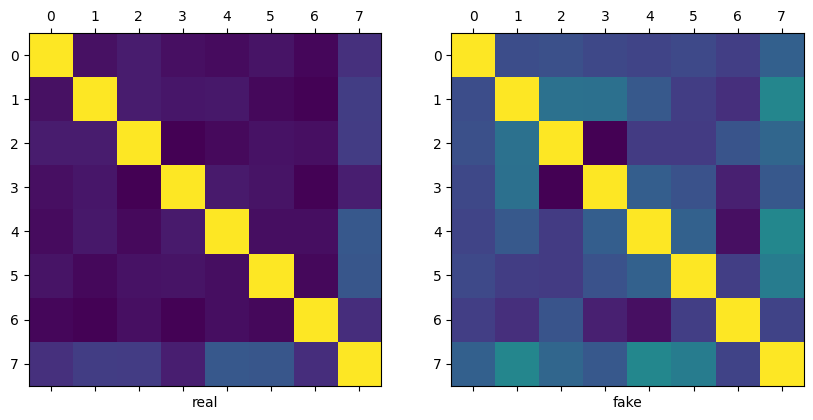

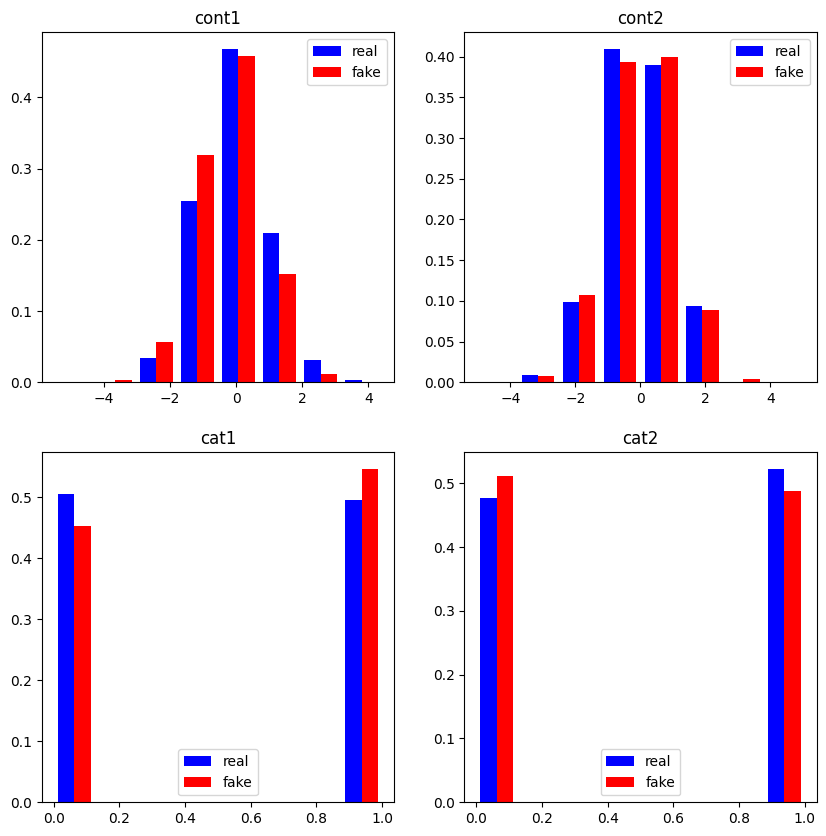

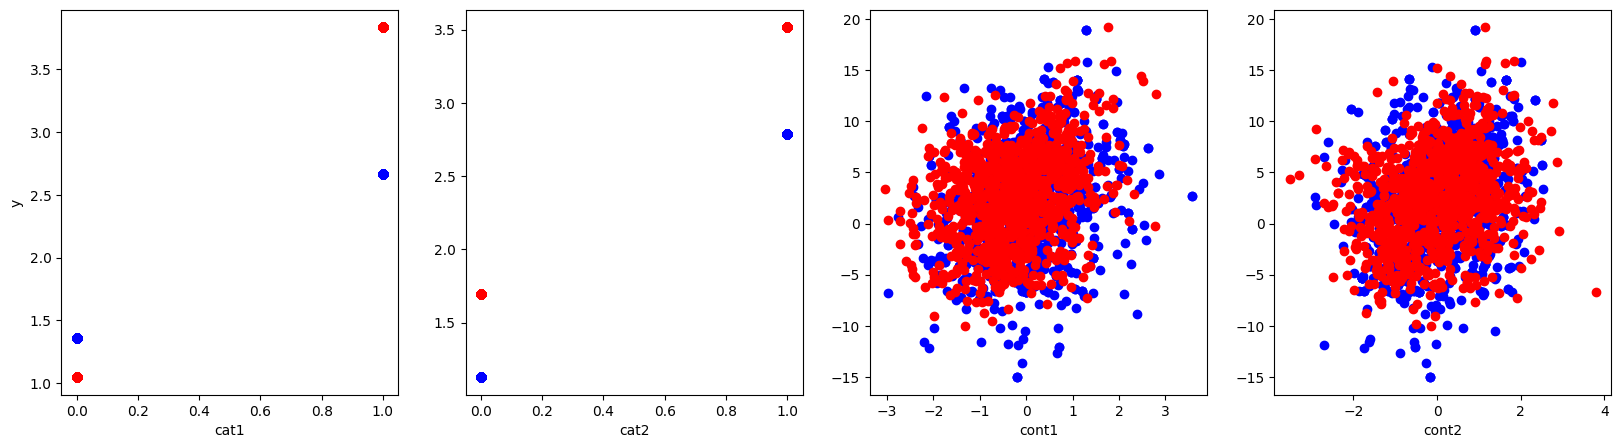

In [24]:
print("att:", ((df_generated.y-df_generated.y_cf) * (2*df_generated.t - 1))[df_generated.t==1].mean())
compare_dfs(df_balanced, df_generated,
                 scatterplot=dict(x=["cat1", "cat2", "cont1", "cont2"], y=["y"], samples=1000, smooth=0),
                 table_groupby=["t"],
                 histogram=dict(variables=['cont1', 'cont2', 'cat1', 'cat2',], nrow=2, ncol=2),
                 figsize=5)

In [25]:
# df_generated.to_csv('df_generated.csv', index = False)
# df_generated.to_csv('df_independent_generated.csv', index = False)
# df_generated.to_csv('df_smallp_generated.csv', index = False)
# df_generated.to_csv('df_complex_generated.csv', index = False)
df_generated.to_csv('df_0.2SNR_generated.csv', index = False)

In [26]:
df_generated.shape

(1000000, 10)